/home/work/Documents/Professional/PhD/classes/2023/Spring_2023/CSE_291_B00/nsl-empirical-analysis/scripts/analysis/nsl_class.py:30: SyntaxWarning: invalid escape sequence '\d'
  match = re.search(".*NSL-\d+-(\d*[\s(a-zA-Z)]*[-\d]*)[\._]?.*", file_name)
/tmp/ipykernel_424226/3008295280.py:190: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


Parse NSL numbers
Parsed 358 entries
                      issue date  release date  file number  url  comment
company                                                                  
Apple                         45            45           45   45        0
Automattic/WordPress           5             5            5    5        0
CREDO Mobile                   2             2            2    2        0
Cloudflare                     1             1            1    1        0
Facebook                      15            15           15   15        0
Google                       272           272          272  272        0
Library Connection             1             1            1    1        0
Microsoft                      1             1            1    1        0
Twilio                         2             2            2    2        0
Twitter                       11            11           11   11        0
Yahoo                          3             3            3    3        0
P

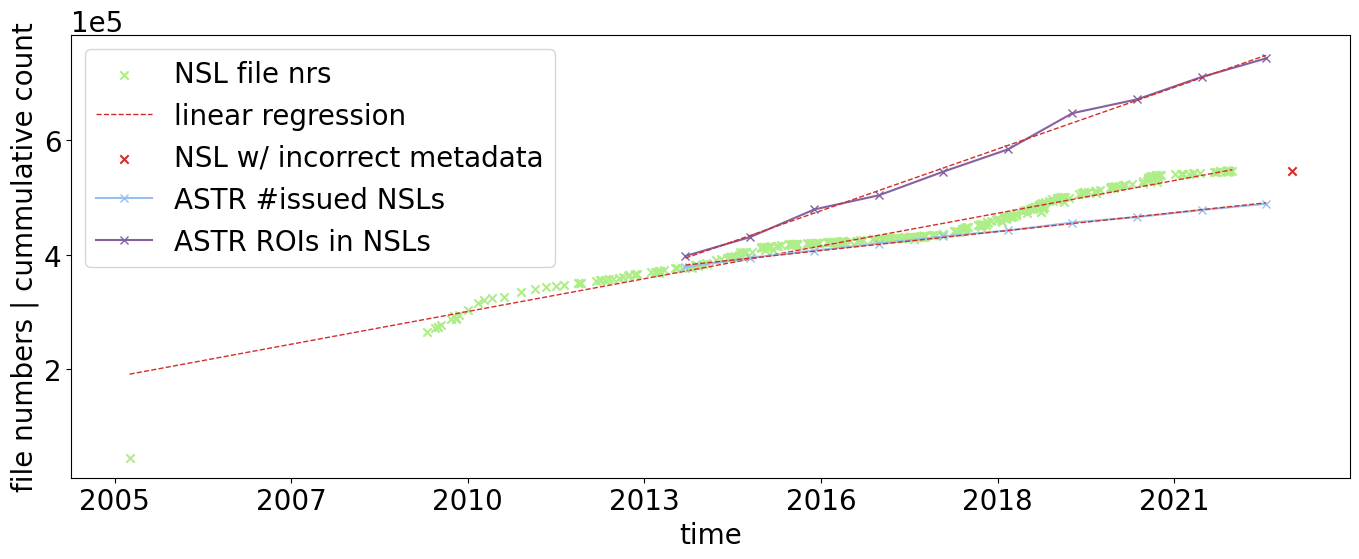

In [3]:
# This file plots NSL file numbers and compares them to ASTR data

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

from nsl_class import NSL

# Optionally, truncate older (and very sparse) data
MIN_YEAR = None

def to_ordinal(xs):
    return list(map(lambda x: x.toordinal(), xs))

def extract_issue_date_and_file_number_from_csv_files(file_paths):
    # Merge all CSVs into one pandas data frame
    df = pd.concat(map(pd.read_csv, file_paths), ignore_index=True)

    # Drop letters with unknown NSL number
    df.dropna(subset=['file number'], inplace=True)
    print(f"Parsed {len(df)} entries")

    # Extract issue date and nsl file number from data frame
    x_axis = []
    y_axis = []
    for idx, row in df.iterrows():
        issue_date = NSL.parse_strftime(row['issue date'])
        # If we use a cutoff, and this letter is outside of the used range, discard
        if MIN_YEAR != None and issue_date.year < MIN_YEAR:
            continue

        x_axis.append(issue_date)
        y_axis.append(NSL.file_str_to_numbers(row['file number']))

    print(df.groupby("company").count())

    return x_axis, y_axis

# NSL data sources
NSL_CSV_FILE_PATHS = [
    "../../data/extracted/nsl_letters_nslarchive.csv",
    "../../data/extracted/nsl_letters_google.csv",
    "../../data/extracted/nsl_letters_apple.csv"
]
print("Parse NSL numbers")
public_available_nsls_x_axis_issue_date, public_available_nsls_y_axis_nsl_number = extract_issue_date_and_file_number_from_csv_files(NSL_CSV_FILE_PATHS)


# Wrong NSL data point 
WRONG_NSL_CSV_FILE_PATHS = [
    "../../data/extracted/nsl_letters_google_wrong.csv"
]
print("Parse fraction of NSL numbers with known mistakes")
wrong_nsls_x_axis_issue_date, wrong_nsls_y_axis_nsl_number = extract_issue_date_and_file_number_from_csv_files(WRONG_NSL_CSV_FILE_PATHS)
wrong_nsls_x_axis_issue_date_ordinal = to_ordinal(wrong_nsls_x_axis_issue_date)

# Read ASTR data from CSV
ASTR_CSV_PATH = "../../data/extracted/fisa_astr_data.csv"
astr_df = pd.read_csv(ASTR_CSV_PATH)

# Create a dictionary with the year as key and the data column as values
astr_nsls_issued = dict(astr_df[["year", "ASTR issued NSLs"]].dropna().values)
astr_rois = dict(astr_df[["year", "ASTR ROIs"]].dropna().values)

# Make keys integer
astr_nsls_issued = {int(k): v for k, v in astr_nsls_issued.items()}
astr_rois = {int(k): v for k, v in astr_rois.items()}

def get_cumulative_data_over_years(data, base_number_of_nsls=0):
    """
    Expects `data` to have data per year.
    Computes the cumulative sum of entries in data: 
    data[0], data[0] + data[1], data[0] + data[1] + data[2], etc.
    """
    x_axis_time = []
    y_axis_total_nsls = []
    # start with base_number_of_nsls if not 0
    total_number_of_nsls = base_number_of_nsls
    for year, number in data.items():
        total_number_of_nsls += number
        x_axis_time.append(datetime(year=year, month=12, day=31))
        y_axis_total_nsls.append(total_number_of_nsls)
    return x_axis_time, y_axis_total_nsls

def find_smallest_relevant_file_nr(data=None, year=None):
    """
    Expects data to have years as keys.

    Find the smallest file number with a timestamp that is
    just before the oldest timestamp in data, or before year.
    """

    # Take the year of the oldest entry in data.
    if year == None:
        year = min(data.keys())
    
    cutoff = datetime(year=year, month=1, day=1)
    smallest_file_number_timestamp = None
    smallest_file_number = None
    # Go through all NSLs to find the oldest one above the cutoff date
    for i, nsl_issue_date in enumerate(public_available_nsls_x_axis_issue_date):
        # Update variable if older NSL above cutoff date was found
        if cutoff <= nsl_issue_date and (smallest_file_number_timestamp == None or nsl_issue_date <= smallest_file_number_timestamp):
            # In case two NSLs are issued on the same day, take the one with the smaller file number
            if smallest_file_number == None or public_available_nsls_y_axis_nsl_number[i] < smallest_file_number:
                smallest_file_number_timestamp = nsl_issue_date
                smallest_file_number = public_available_nsls_y_axis_nsl_number[i]

    return smallest_file_number

print("Processing Issued NSL")
astr_nsls_issued_y_axis_offset = find_smallest_relevant_file_nr(astr_nsls_issued)
astr_nsls_issued_x_axis_time, astr_nsls_issued_y_axis_cumulative_number = get_cumulative_data_over_years(astr_nsls_issued, astr_nsls_issued_y_axis_offset-next(iter(astr_nsls_issued)))

print("Processing ROIs")
astr_rois_y_axis_offset = find_smallest_relevant_file_nr(astr_rois)
astr_rois_in_nsls_x_axis_time, astr_rois_in_nsls_y_axis_cumulative_number = get_cumulative_data_over_years(astr_rois, astr_rois_y_axis_offset-next(iter(astr_rois)))


#
# Plotting
#
plt.rc("axes", axisbelow=True)

plt.rcParams["font.size"] = 20
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,6)

colors = ["#afed89", "#ffc1cc", "#ebc197", "#95c0ef", "#8561a1", 
            "#edc895", "#2c7707", "#9c9ed1", "#ccab0a"]

def poly_regression(xs, ys, deg=1):
    """
    Compute regression on xs, ys with polynomial of degree `deg`
    (for deg=1, this computes the linear regression)
    """                                                                                                                                                                                                        
    print(f"Use degree {deg} polyfit")
    x_vals = np.array(xs)
    coeffs = np.polyfit(xs, np.array(ys), deg=deg)
    new_xs = np.linspace(xs[0], xs[-1], len(x_vals))
    new_ys = []
    for x in new_xs:
        y = 0
        for i, coeff in enumerate(coeffs):
            y += x**(deg-i) * coeff
        new_ys.append(y)

    return new_xs, new_ys

def plot_regression(ax, xs, ys, deg=1, label=None):
    """
    Add a line with the polynomial regression of degree `deg` to axis `ax`
    """
    regression_xs, regression_ys = poly_regression(xs, ys)                                                                                                                                                               
    ax1.plot(regression_xs, regression_ys, linestyle="--", color="#d52d2a", label=label, linewidth=1)

# sort file numbers
public_available_nsls_x_axis_issue_date_ordinal = to_ordinal(public_available_nsls_x_axis_issue_date)
sorted_public_available_nsls_plotting_data = sorted(zip(public_available_nsls_x_axis_issue_date_ordinal, public_available_nsls_y_axis_nsl_number), key=lambda x: x[0])
public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted = map(list, list(zip(*sorted_public_available_nsls_plotting_data)))

# Plotting the numbers acquired from different sources
fig, ax1 = plt.subplots()

# nsl numbers from publicly available nsl files
plt.scatter(public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted, color=colors[0], marker="x", label="NSL file nrs")
plot_regression(ax1, public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted, label="linear regression")

# highlight wrong nsl numbers
plt.scatter(wrong_nsls_x_axis_issue_date_ordinal, wrong_nsls_y_axis_nsl_number, color="#d52d2a", marker="x", label="NSL w/ incorrect metadata")

# number reported in astar
plt.plot(to_ordinal(astr_nsls_issued_x_axis_time), astr_nsls_issued_y_axis_cumulative_number, colors[3], marker="x", label="ASTR #issued NSLs")
plot_regression(ax1, to_ordinal(astr_nsls_issued_x_axis_time), astr_nsls_issued_y_axis_cumulative_number)

# rois reported in astar
plt.plot(to_ordinal(astr_rois_in_nsls_x_axis_time), astr_rois_in_nsls_y_axis_cumulative_number, colors[4], marker="x", label="ASTR ROIs in NSLs")
plot_regression(ax1, to_ordinal(astr_rois_in_nsls_x_axis_time), astr_rois_in_nsls_y_axis_cumulative_number)


ax = plt.gca()
x_ticks = ax.get_xticks()

# set plot xticklabels
new_labels = [datetime.fromordinal(int(item)).year for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Save
plt.xlabel("time")
plt.ylabel("file numbers | cummulative count")
plt.legend(loc="upper left")
plt.tight_layout()

OUTPUT_DATA_DIR = "../../data/processed/"
plt.savefig("{}/file_numbers.pdf".format(OUTPUT_DATA_DIR))
plt.savefig("{}/file_numbers.png".format(OUTPUT_DATA_DIR))

In [4]:
# Identify outliers

from statistics import mean

last_nsl_number = 0
outliers = dict()
for idx, nsl_number in enumerate(public_available_nsls_y_axis_nsl_number_sorted):
    if nsl_number < last_nsl_number:
        outliers[last_nsl_number - nsl_number] = (nsl_number, last_nsl_number, public_available_nsls_x_axis_issue_date_sorted[idx], public_available_nsls_x_axis_issue_date_sorted[idx-1])
    last_nsl_number = nsl_number

print(f"Found {len(outliers)} outliers ({round(100*len(outliers)/len(public_available_nsls_y_axis_nsl_number_sorted), 2)}%), with mean deviation: {100*mean(outliers.keys())/mean(public_available_nsls_y_axis_nsl_number_sorted)}")

for deviation in sorted(outliers.keys(), reverse=True):
    nsl_number, last_nsl_number, nsl_issue_date, last_nsl_issue_date = outliers[deviation]
    print("Outlier:", nsl_number, "last", last_nsl_number, "date", datetime.fromordinal(nsl_issue_date), "date", datetime.fromordinal(last_nsl_issue_date))

Found 80 outliers (22.35%), with mean deviation: 0.42708005412018624
Outlier: 473948.0 last 487709.0 date 2019-07-07 00:00:00 date 2019-07-02 00:00:00
Outlier: 527897.0 last 538486.0 date 2021-04-25 00:00:00 date 2021-04-20 00:00:00
Outlier: 479575.0 last 489668.0 date 2019-07-15 00:00:00 date 2019-07-11 00:00:00
Outlier: 492212.0 last 501392.0 date 2019-11-15 00:00:00 date 2019-11-05 00:00:00
Outlier: 397674.0 last 403866.0 date 2014-11-07 00:00:00 date 2014-11-05 00:00:00
Outlier: 483160.0 last 489147.0 date 2019-07-23 00:00:00 date 2019-07-23 00:00:00
Outlier: 472409.0 last 478371.0 date 2019-04-16 00:00:00 date 2019-04-16 00:00:00
Outlier: 408634.0 last 414420.0 date 2015-05-12 00:00:00 date 2015-04-27 00:00:00
Outlier: 531193.0 last 536932.0 date 2021-03-31 00:00:00 date 2021-03-26 00:00:00
Outlier: 407597.0 last 413278.0 date 2015-03-24 00:00:00 date 2015-03-20 00:00:00
Outlier: 448595.0 last 453528.0 date 2018-07-31 00:00:00 date 2018-07-30 00:00:00
Outlier: 367024.0 last 371110

In [5]:
# Fraction of published NSLs
def fraction_of_published_nsls(from_year, to_year):
    """Return the fraction of NSLs published from `from_year` until (and inclusive) `to_year`"""
    
    total_nsls_issued = 0
    for year, nsls_issued in astr_nsls_issued.items():
        if from_year <= year <= to_year:
            total_nsls_issued += nsls_issued
    
    published_nsls = 0
    for issue_date in public_available_nsls_x_axis_issue_date_ordinal:
        if from_year <= datetime.fromordinal(int(issue_date)).year <= to_year:
            published_nsls += 1
    
    return published_nsls / total_nsls_issued

from_year = 2015
to_year = 2020
print(f"Fraction of NSLs issued from Jan 1, {from_year} to Dec 31, {to_year}:", fraction_of_published_nsls(from_year, to_year))

Fraction of NSLs issued from Jan 1, 2015 to Dec 31, 2020: 0.0031446980391060674
